In [1]:
!pip install xgboost

     |████████████████████████████████| 127.6 MB 1.3 MB/s eta 0:00:012  |█▉                              | 7.5 MB 8.4 MB/s eta 0:00:15     |█████████████████████████▍      | 101.3 MB 11.3 MB/s eta 0:00:03


In [89]:
# And, if needed: sudo apt install graphviz
!pip install graphviz

In [1]:
import xgboost as xgb

In [2]:
import os

In [3]:
if not os.path.exists('lending-club'):
    print("======================================================")
    print("Make sure to download the lending club dataset into `lending-club`")
    print("https://www.kaggle.com/wendykan/lending-club-loan-data")
    print("======================================================")
    assert False

## Explore dataset

In [15]:
import random
import numpy as np
import pandas as pd


In [18]:
filename = 'lending-club/loan.csv'
num_total = sum(1 for line in open(filename)) - 1 # number of records in file (without header)
num_sample = 100_000
skiprows = sorted(random.sample(range(1, num_total+1), num_total-num_sample)) # the 0-indexed header will not be included in the skip list

df = pd.read_csv(filename,
                low_memory=False,  # disables loading in chunks, which in this case causes inconsistent type inference
                skiprows=skiprows  # operating on all rows kills my 16gig memory further down in the notebook. for actual training I'd need all
                )

print(f"Loaded {filename}. Sampled {num_sample} from a total of {num_total} records, which is {100*num_sample/num_total:.1f} percent)")

Loaded lending-club/loan.csv. Sampled 100000 from a total of 2260668, which is 4.4 percent)


In [19]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,6000,6000,6000.0,36 months,13.56,203.79,C,C1,...,NaN,NaN,DirectPay,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,10000,10000,10000.0,36 months,16.14,352.27,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,18000,18000,18000.0,36 months,8.81,570.81,A,A5,...,NaN,NaN,DirectPay,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,8000,8000,8000.0,36 months,10.33,259.38,B,B1,...,NaN,NaN,DirectPay,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,5000,5000,5000.0,36 months,11.31,164.43,B,B3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# Each loan has its official grade ranking provided by Lending Club (let's maybe not use this a a feature)
df.grade.unique()

array(['C', 'A', 'B', 'D', 'E', 'F', 'G'], dtype=object)

In [21]:
# It's even more fine-graned. Same story: This is their official rating, let's be intentional about using/not using it as a feature
df.sub_grade.unique()

array(['C1', 'C4', 'A5', 'B1', 'B3', 'C2', 'C3', 'D2', 'B2', 'B5', 'A4',
       'B4', 'A3', 'A1', 'D1', 'A2', 'D4', 'D5', 'C5', 'E1', 'D3', 'E5',
       'E2', 'E4', 'E3', 'F1', 'F2', 'F3', 'G2', 'G1', 'F4', 'G4', 'F5',
       'G3', 'G5'], dtype=object)

Interest rates ranking from 5.31 to 30.99, median: 12.62, mean 13.0990314


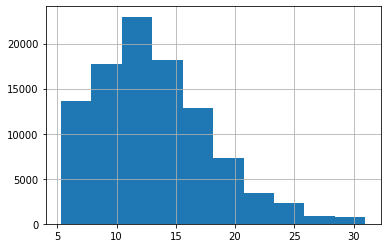

In [22]:
print(f'Interest rates ranking from {df.int_rate.min()} to {df.int_rate.max()}, median: {df.int_rate.median()}, mean {df.int_rate.mean()}')
df.int_rate.hist()

In [23]:
# cool, but not for a dataset with that many features
df.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,url,dti,...,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,0.0,0.0,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,9.999900e+04,0.0,99926.000000,...,484.0,484.000000,484.0,484.000000,389.000000,484.000000,484.000000,1407.000000,1407.000000,1407.000000
mean,NaN,NaN,15055.363500,15050.119500,15032.282134,13.099031,446.338756,7.769280e+04,NaN,18.876143,...,3.0,155.633161,3.0,13.237603,463.283676,11496.918450,201.890207,4996.838785,47.768088,12.722814
std,NaN,NaN,9202.965189,9201.030979,9204.300629,4.843025,267.803147,6.342335e+04,NaN,14.946878,...,0.0,130.948140,0.0,9.685069,394.559066,7561.395595,200.744403,3606.932033,7.147461,8.224616
min,NaN,NaN,700.000000,700.000000,0.000000,5.310000,21.990000,0.000000e+00,NaN,-1.000000,...,3.0,2.690000,3.0,0.000000,14.310000,239.790000,0.010000,173.000000,19.460000,0.000000
25%,NaN,NaN,8000.000000,8000.000000,8000.000000,9.490000,251.647500,4.640000e+04,NaN,11.920000,...,3.0,57.800000,3.0,1.000000,174.240000,5624.755000,43.782500,2287.710000,45.000000,6.000000
50%,NaN,NaN,12900.000000,12875.000000,12800.000000,12.620000,377.410000,6.500000e+04,NaN,17.880000,...,3.0,117.800000,3.0,14.000000,350.910000,10201.350000,138.855000,4241.000000,45.010000,12.000000
75%,NaN,NaN,20000.000000,20000.000000,20000.000000,15.990000,594.620000,9.244649e+04,NaN,24.490000,...,3.0,217.925000,3.0,21.250000,595.530000,15768.907500,315.025000,6819.105000,50.000000,18.000000
max,NaN,NaN,40000.000000,40000.000000,40000.000000,30.990000,1714.540000,5.990095e+06,NaN,999.000000,...,3.0,769.030000,3.0,30.000000,2307.090000,36734.040000,1407.860000,26751.740000,166.670000,65.000000


In [24]:
# Probably our target variable: Was the loan repaid in the end?
df.loan_status.value_counts()

Fully Paid                                             45855
Current                                                40992
Charged Off                                            11532
Late (31-120 days)                                       948
In Grace Period                                          380
Late (16-30 days)                                        167
Does not meet the credit policy. Status:Fully Paid        81
Does not meet the credit policy. Status:Charged Off       44
Default                                                    1
Name: loan_status, dtype: int64

In [25]:
# Determining the loans that are bad from loan_status column
# Source of this snippet: https://www.kaggle.com/janiobachmann/lending-club-risk-analysis-and-metrics

bad_loan_columns = [
    "Charged Off",
    "Default",
    "Does not meet the credit policy. Status:Charged Off",
    "In Grace Period", 
    "Late (16-30 days)",
    "Late (31-120 days)"
]

df['loan_condition'] = np.nan    
df['loan_condition'] = df['loan_status'].apply(lambda status: status in bad_loan_columns)

In [26]:
df.loan_condition.value_counts()

False    86928
True     13072
Name: loan_condition, dtype: int64

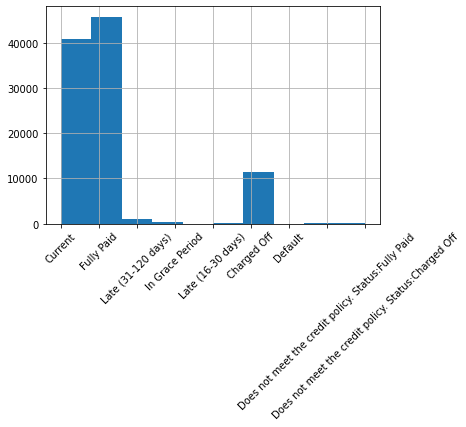

In [27]:
df.loan_status.hist(xrot=45)

In [83]:
# print("\n".join(df.columns))

In [85]:
# list(df.select_dtypes(include=[np.number]).columns.values)

## Prepare dataset for training

In [98]:
df_for_training = df.drop(columns=[
    # these features only exist past facto, so we dont want them to predict bad debt
    'grade',
    'sub_grade',
    'recoveries',
    'total_rec_late_fee',
    'last_pymnt_amnt',
    # these features are individual identifiers and dont help the classifier
    'url',
    'id',
    'member_id'])
df_for_training

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_title,emp_length,home_ownership,annual_inc,...,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,loan_condition
0,6000,6000,6000.0,36 months,13.56,203.79,Assistant Director,10+ years,RENT,65000.0,...,NaN,DirectPay,N,NaN,NaN,NaN,NaN,NaN,NaN,False
1,10000,10000,10000.0,36 months,16.14,352.27,NaN,< 1 year,MORTGAGE,90000.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,False
2,18000,18000,18000.0,36 months,8.81,570.81,Sever,< 1 year,RENT,40000.0,...,NaN,DirectPay,N,NaN,NaN,NaN,NaN,NaN,NaN,False
3,8000,8000,8000.0,36 months,10.33,259.38,Optician,6 years,MORTGAGE,38000.0,...,NaN,DirectPay,N,NaN,NaN,NaN,NaN,NaN,NaN,False
4,5000,5000,5000.0,36 months,11.31,164.43,Shipping,2 years,RENT,40000.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,12000,12000,11750.0,36 months,11.99,398.52,Engineering Technician,2 years,RENT,63000.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,False
99996,10000,10000,10000.0,36 months,18.06,361.83,attorney,4 years,RENT,85000.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,False
99997,11200,11200,11200.0,60 months,21.45,305.84,Supervisor,10+ years,MORTGAGE,82000.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,False
99998,21625,21625,21625.0,36 months,17.09,771.96,teacher,10+ years,MORTGAGE,83000.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,True


In [99]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_for_training, test_size=0.2)

In [100]:
train.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_title,emp_length,home_ownership,annual_inc,...,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,loan_condition
4919,6000,6000,6000.0,36 months,16.14,211.36,NaN,NaN,OWN,46000.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,False
90094,10000,10000,10000.0,60 months,15.61,241.12,Manager,10+ years,MORTGAGE,69300.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,False
64342,15000,15000,15000.0,60 months,16.02,364.94,driver,3 years,MORTGAGE,62000.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,False
50727,12000,12000,12000.0,60 months,14.65,283.28,Administrative Assistant,< 1 year,OWN,40000.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,True
24344,15000,15000,15000.0,60 months,14.49,352.85,Pricing Manager,6 years,MORTGAGE,72000.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,False


In [101]:
# convert target to 0 and 1
y_train = train.loan_condition.apply(int)
y_test = test.loan_condition.apply(int)

# remove target from features
x_train = train.drop(columns=['loan_condition'])
x_test = test.drop(columns=['loan_condition'])

# for now: only work on numerical features.
# TODO: we can also make categorical ones work
x_train = (
    x_train
   .select_dtypes(include=[np.number])
)
x_test = (
    x_test
    .select_dtypes(include=[np.number])
)

# impute NaN values
x_train = x_train.fillna(x_train.mean())
x_test = x_test.fillna(x_test.mean())

In [102]:
x_train

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,...,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
4919,6000,6000,6000.0,16.14,211.36,46000.0,14.43,1.0,2.0,20.000000,...,3.0,153.026349,3.0,13.420635,456.201159,11257.510026,196.495132,4994.702992,47.894211,12.866113
90094,10000,10000,10000.0,15.61,241.12,69300.0,24.21,2.0,0.0,16.000000,...,3.0,153.026349,3.0,13.420635,456.201159,11257.510026,196.495132,4994.702992,47.894211,12.866113
64342,15000,15000,15000.0,16.02,364.94,62000.0,16.33,0.0,0.0,34.564903,...,3.0,153.026349,3.0,13.420635,456.201159,11257.510026,196.495132,4994.702992,47.894211,12.866113
50727,12000,12000,12000.0,14.65,283.28,40000.0,29.61,0.0,0.0,34.564903,...,3.0,153.026349,3.0,13.420635,456.201159,11257.510026,196.495132,4994.702992,47.894211,12.866113
24344,15000,15000,15000.0,14.49,352.85,72000.0,23.03,0.0,0.0,36.000000,...,3.0,153.026349,3.0,13.420635,456.201159,11257.510026,196.495132,4994.702992,47.894211,12.866113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14954,10000,10000,10000.0,10.90,326.92,63000.0,10.32,0.0,0.0,34.564903,...,3.0,153.026349,3.0,13.420635,456.201159,11257.510026,196.495132,4994.702992,47.894211,12.866113
20795,10000,10000,10000.0,11.99,222.40,55000.0,16.50,0.0,0.0,34.564903,...,3.0,153.026349,3.0,13.420635,456.201159,11257.510026,196.495132,4994.702992,47.894211,12.866113
62148,7000,7000,7000.0,8.24,220.14,50000.0,19.23,0.0,0.0,47.000000,...,3.0,153.026349,3.0,13.420635,456.201159,11257.510026,196.495132,4994.702992,47.894211,12.866113
36124,6000,6000,6000.0,14.85,207.56,62000.0,13.52,0.0,1.0,32.000000,...,3.0,153.026349,3.0,13.420635,456.201159,11257.510026,196.495132,4994.702992,47.894211,12.866113


In [103]:
# Targets should be ones and zeros
y_train

4919     0
90094    0
64342    0
50727    1
24344    0
        ..
14954    0
20795    0
62148    0
36124    0
63711    0
Name: loan_condition, Length: 80000, dtype: int64

In [104]:
# How many features do we train on? -> 106
x_train.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,...,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
4919,6000,6000,6000.0,16.14,211.36,46000.0,14.43,1.0,2.0,20.000000,...,3.0,153.026349,3.0,13.420635,456.201159,11257.510026,196.495132,4994.702992,47.894211,12.866113
90094,10000,10000,10000.0,15.61,241.12,69300.0,24.21,2.0,0.0,16.000000,...,3.0,153.026349,3.0,13.420635,456.201159,11257.510026,196.495132,4994.702992,47.894211,12.866113
64342,15000,15000,15000.0,16.02,364.94,62000.0,16.33,0.0,0.0,34.564903,...,3.0,153.026349,3.0,13.420635,456.201159,11257.510026,196.495132,4994.702992,47.894211,12.866113
50727,12000,12000,12000.0,14.65,283.28,40000.0,29.61,0.0,0.0,34.564903,...,3.0,153.026349,3.0,13.420635,456.201159,11257.510026,196.495132,4994.702992,47.894211,12.866113
24344,15000,15000,15000.0,14.49,352.85,72000.0,23.03,0.0,0.0,36.000000,...,3.0,153.026349,3.0,13.420635,456.201159,11257.510026,196.495132,4994.702992,47.894211,12.866113


## XGBoost

In [105]:
# xgboost prefers its own data dataformat. But we can convert from the pandas dataframe
# https://xgboost.readthedocs.io/en/latest/python/python_intro.html#data-interface
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)


param = {
    'max_depth': 2,
    'eta': 1,
    'objective': 'binary:logistic'
}
num_rounds = 2
bst = xgb.train(param, dtrain, num_rounds)

In [106]:
y_pred = bst.predict(dtest)

In [107]:
y_pred.shape

(20000,)

## Evaluate classifier performance

In [108]:
import math
from sklearn.metrics import classification_report

In [109]:
# convert float scores to zeros and ones
y_pred_binary = [int(round(score)) for score in y_pred]

report = classification_report(
    y_true=y_test,
    y_pred=y_pred_binary,
    target_names=["Good loan", "Bad Loan"]
)

print(report)

              precision    recall  f1-score   support

   Good loan       0.94      1.00      0.97     17370
    Bad Loan       1.00      0.59      0.74      2630

    accuracy                           0.95     20000
   macro avg       0.97      0.79      0.85     20000
weighted avg       0.95      0.95      0.94     20000



## What has the model learned?

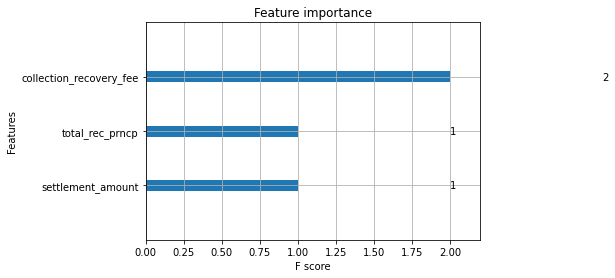

In [110]:
xgb.plot_importance(bst)

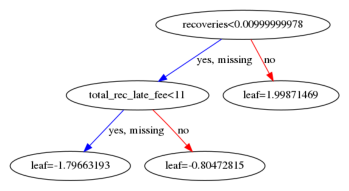

In [94]:
xgb.plot_tree(bst)

## TODO: Hand-remove features before training!
disable all features which only exist for loans after they have clearly defaultet (like late collection fees). Otherwise the model will simply look at them. When a new user applies for a loan, we obviously do not have that data yet. 

To understand what each feature means, there is a table in the xls file that comes with the dataset. Unfortunately it does not seem to include all features, or they are spelled differently.